# Geolocalization analysis and data vizualization

__Scope__: 
Optimize leaflet distribution viewing customers on the map

### Import libraries

In [1]:
import pandas as pd # data Extract Transform Load
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # plotting
%matplotlib inline

import sys # system operations

In [2]:
# machine learning libs
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

### Load Data Frame

In [3]:
main_path =sys.path[0]
path_data ="/data_geovisitors/onlygeo_with_ip.csv"
df = pd.read_csv(main_path+path_data,';')
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,URL,IP,LAT,LNG
0,2020/06/30,17:07:06,GEO,cavalletto_alzamoto,79.0.55.117,45.778774,12.060474
1,2020/06/30,17:52:39,GEO,cavalletto_alzamoto,79.0.55.117,45.778950,12.060603
2,2020/06/30,18:14:18,GEO,cavalletto_alzamoto,37.162.228.228,45.778738,12.060630
3,2020/06/30,18:14:44,GEO,cavalletto_alzamoto,37.162.228.228,45.778647,12.060690
4,2020/06/30,18:23:17,GEO,cavalletto_alzamoto,37.162.228.228,45.778647,12.060690


In [4]:
# change columns name
df[df.columns[0]] = 'date'
df[df.columns[1]] = 'time'
df[df.columns[2]] = 'geolock'

### Get the map for your boundries.

 Insert the max and min of latitude and longitude that I choosed in this site and download the map.
 With OpenStreetMap.org I download the map that I want for my coordinates. Select Layers / OVNKarte option at right for more address into the map.




**Sites**.
- Tutorial how download the map:
https://medium.com/@abuqassim115/thanks-for-your-response-frank-fb869824ede2


- OpenStreetMap.org
https://www.openstreetmap.org/export#map=5/51.500/-0.100



**Examples**.

- North-Italy zone
https://www.openstreetmap.org/#map=6/43.077/8.262


- Specific italian city : Montebelluna
https://www.openstreetmap.org/#map=13/45.7745/12.0216

Take the coordinates data in the Data Frame only from the previous set boundries. 

### From street address to coordinates
https://developers-dot-devsite-v2-prod.appspot.com/maps/documentation/utils/geocoder

### Data Structure

In [5]:
path_map_img = main_path+"/img/only-map/"

In [6]:
global cities
cities = { 'padova':{'map_path':path_map_img+'padova.png',  
                                     'lat_max':45.4476,
                                     'lat_min':45.3657,
                                     'lng_max':11.9868,
                                     'lng_min':11.7942,
                     
                     'coordinate_store':{'lat':45.412749,
                                         'lng':11.919453
                                        }
                    },
          
          'montebelluna':{'map_path':path_map_img+'montebelluna.png',
                                     'lat_max':45.7951,
                                     'lat_min':45.7544,
                                     'lng_max':12.0811,
                                     'lng_min':12.0063,
              
                     'coordinate_store':{'lat':45.779023,
                                         'lng':12.06014
                                        }
                        }
          
         }

In [7]:
def extract_boundries(data_cities,city_name):
    """
    extract latitude and longitude min/max
    from the data set with dictionary keys
    """
    lat_max = data_cities[city_name]['lat_max']
    lat_min = data_cities[city_name]['lat_min']
    lng_max = data_cities[city_name]['lng_max']
    lng_min = data_cities[city_name]['lng_min']
    
    return([lat_max,lat_min,lng_max,lng_min])

In [8]:
def filter_df_for_plot(df,data_cities,city_name):
    """
    filter dataframe with the boundries 
    of the city map
    """
    boundries=extract_boundries(data_cities,city_name)

    df_filtered = df[ 
                (df['LAT']< boundries[0]) &
                (df['LAT']>= boundries[1]) &
                (df['LNG']< boundries[2]) &
                (df['LNG']>= boundries[3])]
    
    return df_filtered

In [9]:
def create_bbox(boundries):
    # BBox serves for the plotting size figures
    BBox = ((boundries[3],   boundries[2],      
             boundries[1], boundries[0]))
    return BBox

In [10]:
path_to_save_imgs = main_path+"/img/map-with-points/"

def plot_map(city_name,df=df,data_cities=cities):

    # set boundries
    boundries = extract_boundries(data_cities,city_name)
    bbox = create_bbox(boundries)
    
    # store coordinates
    X_store_coordinates = data_cities[city_name]['coordinate_store']['lng']
    Y_store_coordinates = data_cities[city_name]['coordinate_store']['lat']

    # load background img
    IMG=plt.imread(path_map_img+city_name+'.png')
    
    # create figure
    fig, ax = plt.subplots()
    
    # plot
    ax.scatter(df.LNG, df.LAT, zorder=1, alpha=0.5 , c='r', s=10)
    ax.scatter(X_store_coordinates,Y_store_coordinates,c='b', s=50)
    
    # set figure boundries
    ax.set_xlim(bbox[0],bbox[1])
    ax.set_ylim(bbox[2],bbox[3])
    
    # estetics
    plt.title(" Client map of {0} ".format(city_name[:1].upper()+city_name[1:]))
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
    # show
    ax.imshow(IMG, zorder=0, extent = bbox, aspect= 'auto')
    
    # save
    fig.savefig(path_to_save_imgs+city_name+'.png', dpi=300, bbox_inches='tight')



In [11]:
def main_plot(city_name,data_cities=cities, dataframe=df):
    """go to cities dictionary
    extract boundries latitude min/max and longitude min/max
    filter the dataframe of cli
    ents with the boundries
    extract img path and plot over it each client and the store position
    """
    dataframe = filter_df_for_plot(dataframe, data_cities ,city_name)
    plot_map(city_name,dataframe)
    

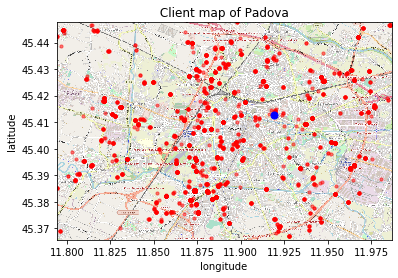

In [12]:
main_plot('padova')

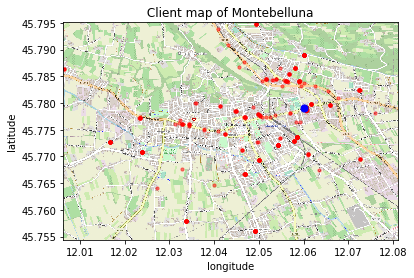

In [13]:
main_plot('montebelluna')

### CLUSTERING

In [17]:
def filter_df_for_clustering(df,city_name, data_cities=cities):   
    boundries=extract_boundries(data_cities,city_name)
    df_filtered = df[ 
                (df['LAT']< boundries[0]) &
                (df['LAT']>= boundries[1]) &
                (df['LNG']< boundries[2]) &
                (df['LNG']>= boundries[3])]
    
    df_filtered2 = df_filtered[['LAT', 'LNG']]
    return df_filtered2


def hierarchical_clustering(city_name,df,N_cluster=5,data_cities=cities):

    # machine learning
    cluster = AgglomerativeClustering(n_clusters= N_cluster, affinity='euclidean', linkage='ward')  
    cluster.fit_predict(df)
    
    # SETTINGs
    point_dimention = 4 # [ 0.1 - 100 ]
    opacity = 0.8 # [ 0.01 - 1 ]
    
    # PLOT
    plt.figure(figsize=(50, 20))
    

        # set boundries
    boundries = extract_boundries(data_cities,city_name)
    bbox = create_bbox(boundries)
    
    # store coordinates
    X_store_coordinates = data_cities[city_name]['coordinate_store']['lng']
    Y_store_coordinates = data_cities[city_name]['coordinate_store']['lat']

    # load background img
    IMG=plt.imread(path_map_img+city_name+'.png')
    
    # create figure
    fig, ax = plt.subplots()
    
    # plot
    ax.scatter(np.array(df['LNG']),np.array(df['LAT']),
              alpha= opacity , c=cluster.labels_,
               cmap='gist_rainbow_r',marker='o', s = point_dimention)
    
    ax.scatter(X_store_coordinates,Y_store_coordinates, c ='r', s=30)
    
    # set figure boundries
    ax.set_xlim(bbox[0],bbox[1])
    ax.set_ylim(bbox[2],bbox[3])
    
    # estetics
    plt.title(" Clusters of client map of {0} ".format(city_name[:1].upper()+city_name[1:]))
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
    # show
    ax.imshow(IMG, zorder=0, extent = bbox, aspect= 'auto')
    
    # save
    fig.savefig(path_to_save_imgs+city_name+'_cluster.png', dpi=1200, bbox_inches='tight')
    
    
def main_clustering(city_name,N_cluster=20,data_cities=cities,dataframe=df):
    dataframe=filter_df_for_clustering(df, city_name,data_cities)
    hierarchical_clustering(city_name,dataframe,N_cluster)

<Figure size 3600x1440 with 0 Axes>

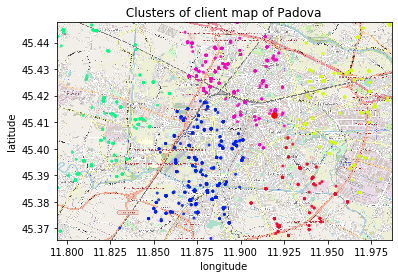

In [18]:
main_clustering('padova',5)

<Figure size 3600x1440 with 0 Axes>

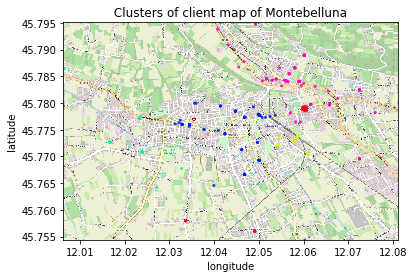

In [19]:
main_clustering('montebelluna',5)